In [1]:
import tensorflow as tf

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
#!pip install -q -U imgaug

In [3]:
#!python.exe -m pip install --upgrade pip

In [4]:
#!wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [5]:
#!tar xf images.tar
#!unzip -qq ~/stanfordextra_v12.zip

In [6]:
from tensorflow.keras import layers
import tensorflow.keras

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 24 * 2  # 24 pairs each having x and y coordinates

In [8]:
IMG_DIR = "Images"
JSON = "StanfordExtra_V12/StanfordExtra_v12.json"
KEYPOINT_DEF = (
    "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
json_dict = {i["img_path"]: i for i in json_data}

In [9]:
len(json_dict)

12538

In [10]:
json_dict['n02085782-Japanese_spaniel/n02085782_2886.jpg']

{'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
 'img_width': 350,
 'img_height': 272,
 'img_bbox': [205, 20, 116, 201],
 'is_multiple_dogs': False,
 'joints': [[108.66666666666667, 252.0, 1],
  [147.66666666666666, 229.0, 1],
  [163.5, 208.5, 1],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [54.0, 244.0, 1],
  [77.33333333333333, 225.33333333333334, 1],
  [79.0, 196.5, 1],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [150.66666666666666, 86.66666666666667, 1],
  [88.66666666666667, 73.0, 1],
  [116.0, 106.33333333333333, 1],
  [109.0, 123.33333333333333, 1],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0]],
 'seg': 'Yi71c01S74jHNU75gHMX75eHM[74cHM\\76`HL4HQ7k0lHXOT7R1O2N010O010jLiNROW1m0lNROT1m0oNPOQ1P1QOoNn0R1ROnNn0oMkNQ2:Nl0oMlNQ2:0j0nMnNP291j0mMoNR280j0kMPOLEg1c0`0i0lMCb1Db0i0jMGa1Ae0h0iMI`1_Og0j0fMK`1\\Oj0i0eMN^1ZOl0i0dM1]1WOm0k0cM2]1TOP1j0bM4\\1ROR1k0`M<W1iNX1l0`M=:ZN4=Q2T3aMXLO8>=Q2k3oMULQ2k3oMTLQ2m3mMULS2j3mMWLS2i3kMY

In [11]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,Left front leg: paw,d82400,y,y,L_F_Paw
1,1,Left front leg: middle joint,d82400,y,y,L_F_Knee
2,2,Left front leg: top,d82400,y,y,L_F_Elbow
3,3,Left rear leg: paw,fcfc00,y,y,L_B_Paw
4,4,Left rear leg: middle joint,fcfc00,y,y,L_B_Knee


In [12]:
# Extract the colours and labels.
colours = keypoint_def["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

In [13]:
# Utility for reading an image and for getting its annotations.
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

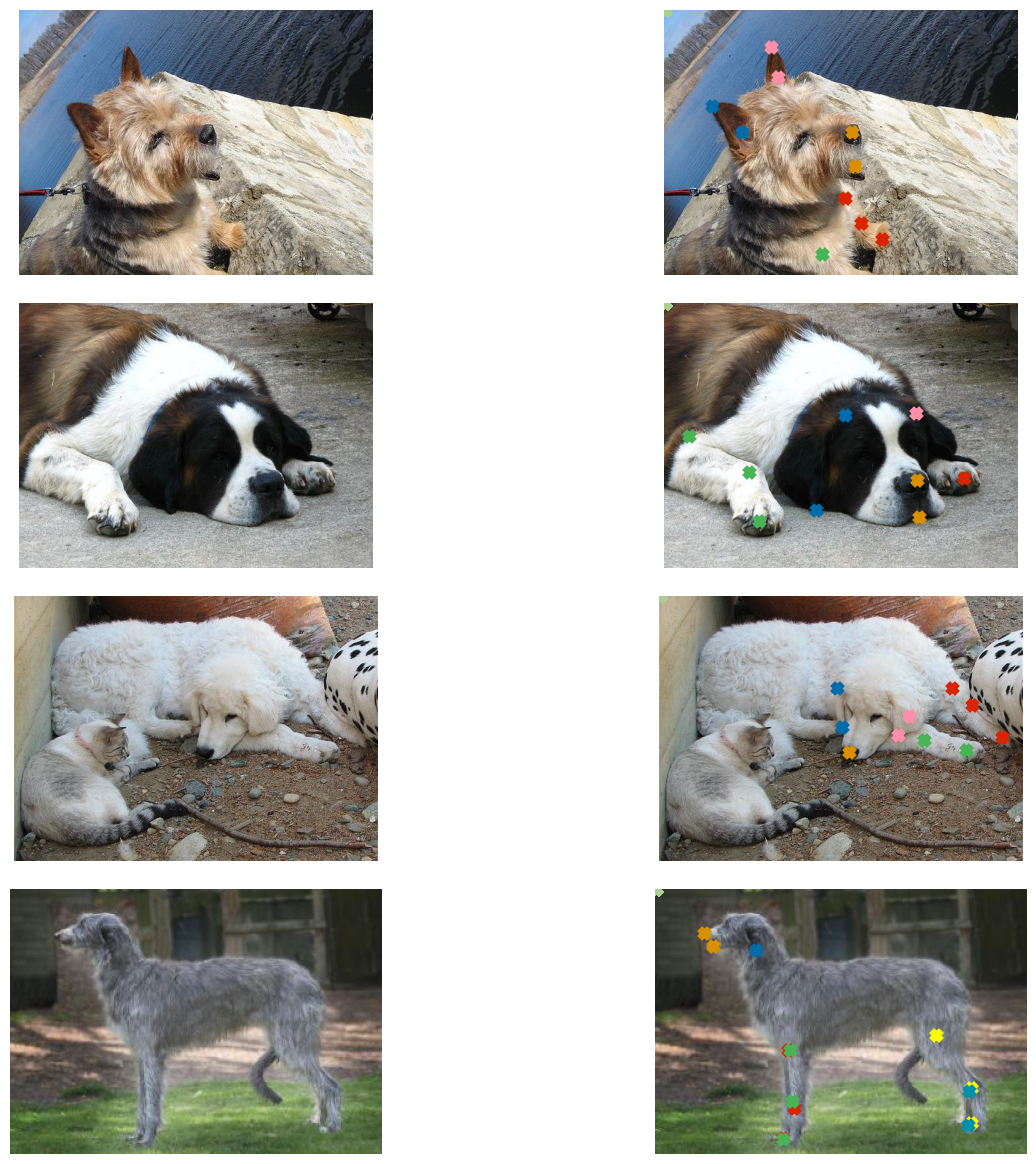

In [14]:
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    c=colours[idx],
                    marker="x",
                    s=50,
                    linewidths=5,
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In [15]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True, **kwargs):
        super().__init__(**kwargs)
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 24 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [16]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [17]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

Total batches in training set: 166
Total batches in validation set: 29


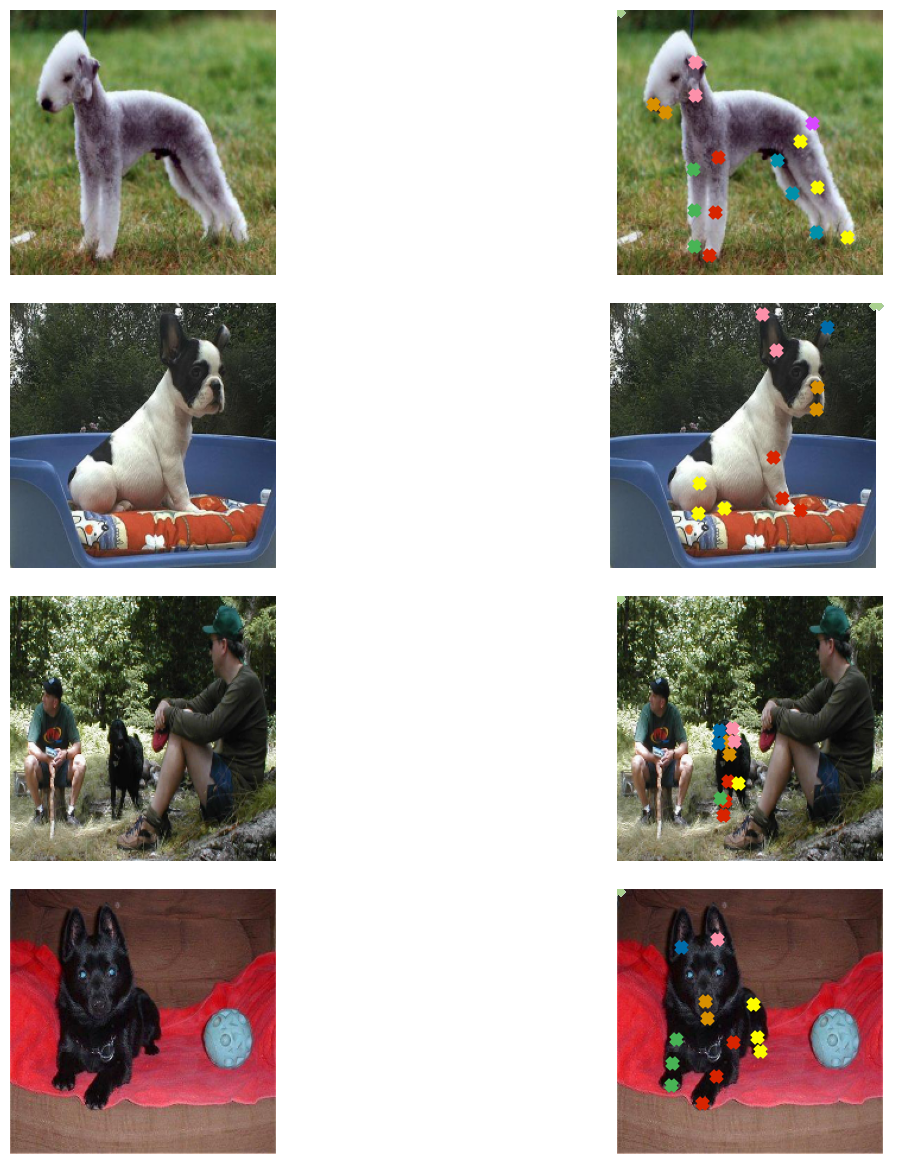

In [18]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [19]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = tf.keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return tf.keras.Model(inputs, outputs, name="keypoint_detector")

In [20]:
get_model().summary()

Model: "keypoint_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 3, 3, 48)          93488     
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 1, 1, 48)    

In [21]:
model = get_model()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/5
166/166 [==============================] - 397s 2s/step - loss: 0.1018 - val_loss: 0.0955
Epoch 2/5
166/166 [==============================] - 327s 2s/step - loss: 0.0816 - val_loss: 0.0794
Epoch 3/5
166/166 [==============================] - 330s 2s/step - loss: 0.0773 - val_loss: 0.0747
Epoch 4/5
166/166 [==============================] - 274s 2s/step - loss: 0.0752 - val_loss: 0.0715
Epoch 5/5
166/166 [==============================] - 306s 2s/step - loss: 0.0737 - val_loss: 0.0702


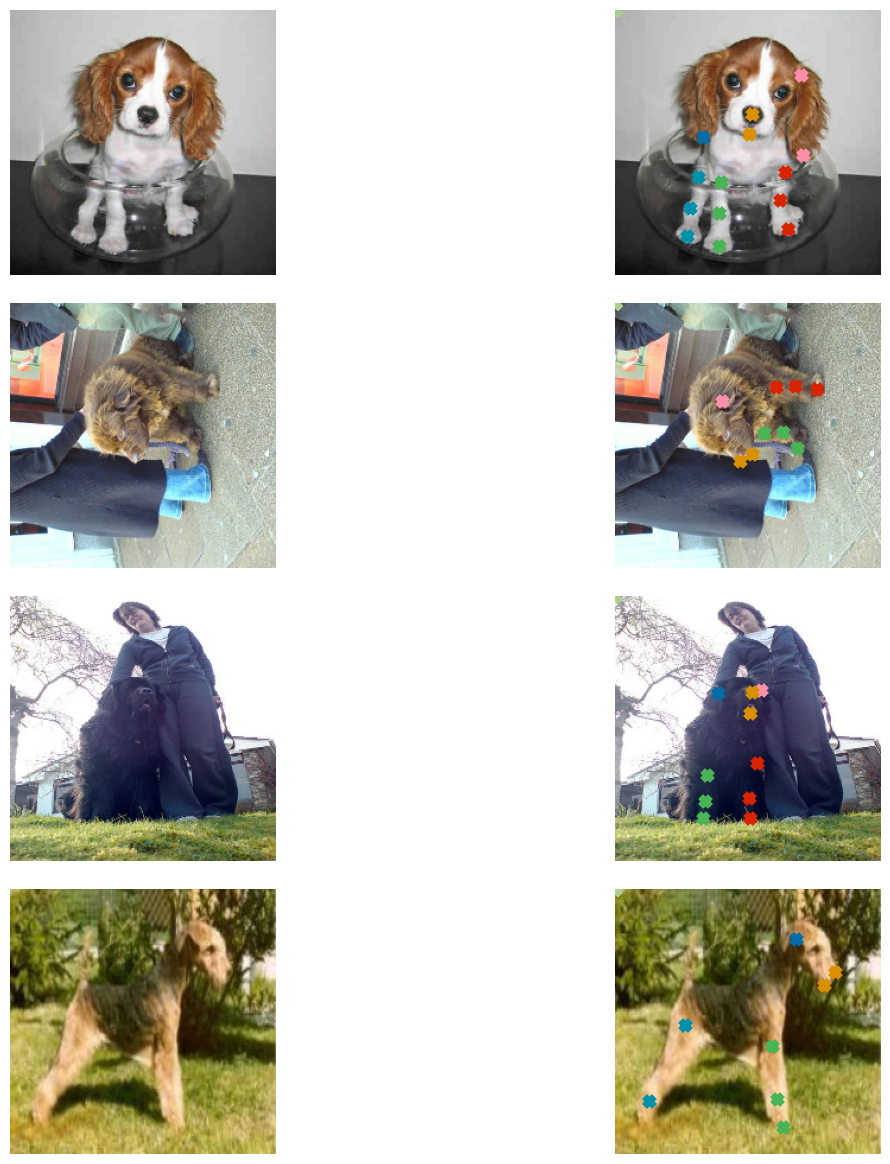

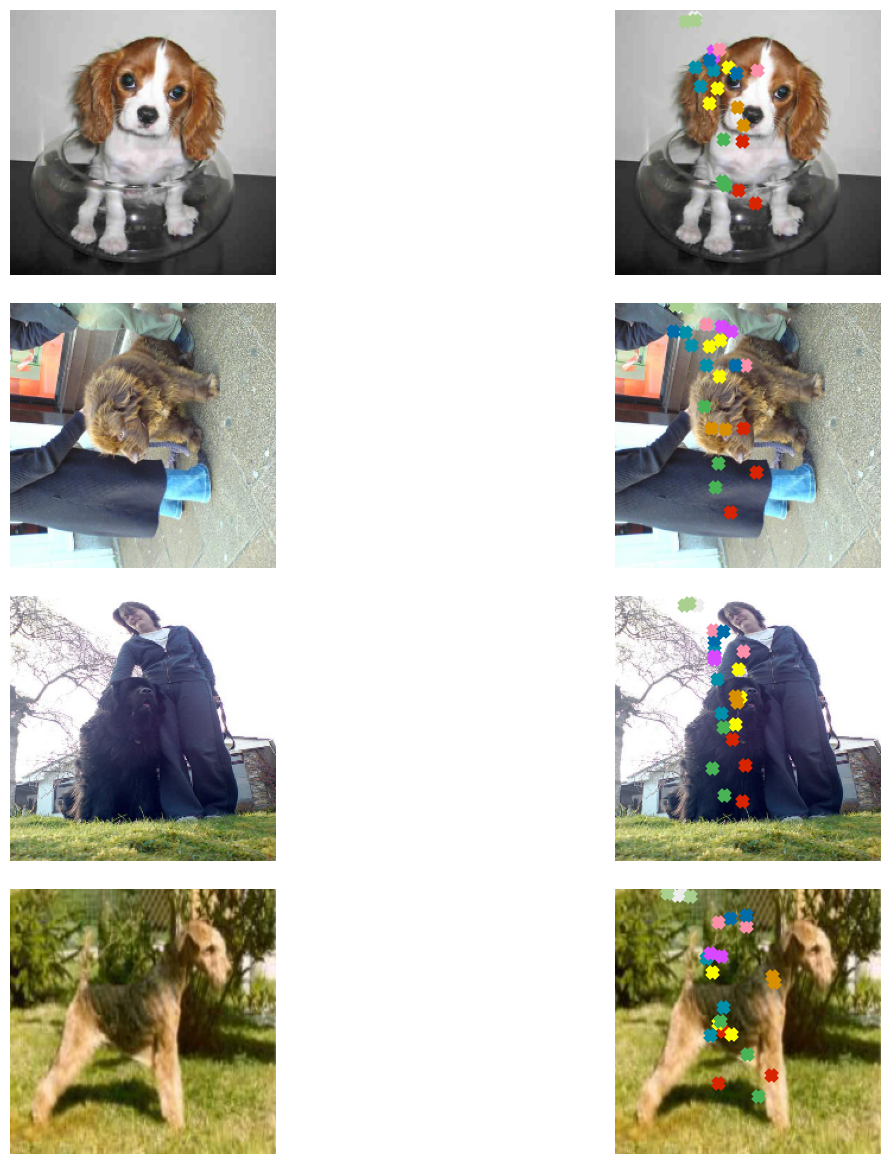

In [22]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)